In [21]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [40]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= Dense(128,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(4,activation='softmax')(x) #FC-layer

In [41]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [42]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [43]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block13_2_conv (Conv2D)   (None, 8, 8, 32)     36864       conv4_block13_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block13_concat (Concatena (None, 8, 8, 672)    0           conv4_block12_concat[0][0]       
                                                                 conv4_block13_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_0_bn (BatchNormal (None, 8, 8, 672)    2688        conv4_block13_concat[0][0]       
__________________________________________________________________________________________________
conv4_block14_0_relu (Activatio (None, 8, 8, 672)    0           conv4_block14_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

In [44]:
import nibabel as nib
import skimage.transform as skTrans

data=[]
imagePaths = sorted(list(os.listdir("data/studies")))
print(imagePaths)
for img in imagePaths:
    path=sorted(list(os.listdir("data/studies/"+img)))
    for i in path:
        img_path = "data/studies/"+str(img)+'/'+str(i)
        image = nib.load(img_path)
        image_d = image.get_fdata()
        queue = image.dataobj.shape[2]
        img_arr = skTrans.resize(image_d, (128, 128, queue), order=1, preserve_range=True)
        img_arrs = img_arr[:,:,queue//2-3:queue//2]      
        data.append((img_arrs, int(img[-1])))

['CT-0', 'CT-1', 'CT-2', 'CT-3']


In [45]:
random.seed(0)
random.shuffle(data)
image_data = []
classes = []
for d in data:
    image_data.append(d[0])
    classes.append(d[1])
image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)
print(classes[0])

[0 1 0 0]


In [46]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(886, 128, 128, 3) (222, 128, 128, 3)


In [47]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=256),
               steps_per_epoch=xtrain.shape[0] //256,
               epochs=50,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))



Epoch 1/50
3/3 - 20s - loss: 2.2024 - accuracy: 0.2873 - val_loss: 2.4873 - val_accuracy: 0.1050

Epoch 00001: val_loss improved from inf to 2.48734, saving model to model.h5
Epoch 2/50
3/3 - 5s - loss: 2.0591 - accuracy: 0.3000 - val_loss: 2.5825 - val_accuracy: 0.2065

Epoch 00002: val_loss did not improve from 2.48734
Epoch 3/50
3/3 - 5s - loss: 1.9982 - accuracy: 0.3000 - val_loss: 2.3877 - val_accuracy: 0.2427

Epoch 00003: val_loss improved from 2.48734 to 2.38772, saving model to model.h5
Epoch 4/50
3/3 - 5s - loss: 1.7931 - accuracy: 0.3333 - val_loss: 2.2983 - val_accuracy: 0.2438

Epoch 00004: val_loss improved from 2.38772 to 2.29831, saving model to model.h5
Epoch 5/50
3/3 - 5s - loss: 1.8386 - accuracy: 0.3424 - val_loss: 2.1072 - val_accuracy: 0.2381

Epoch 00005: val_loss improved from 2.29831 to 2.10724, saving model to model.h5
Epoch 6/50
3/3 - 5s - loss: 1.6406 - accuracy: 0.3635 - val_loss: 2.0703 - val_accuracy: 0.2506

Epoch 00006: val_loss improved from 2.10724 to


Epoch 00049: val_loss improved from 0.73881 to 0.73321, saving model to model.h5
Epoch 50/50
3/3 - 6s - loss: 0.8363 - accuracy: 0.6680 - val_loss: 0.7369 - val_accuracy: 0.7280

Epoch 00050: val_loss did not improve from 0.73321


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

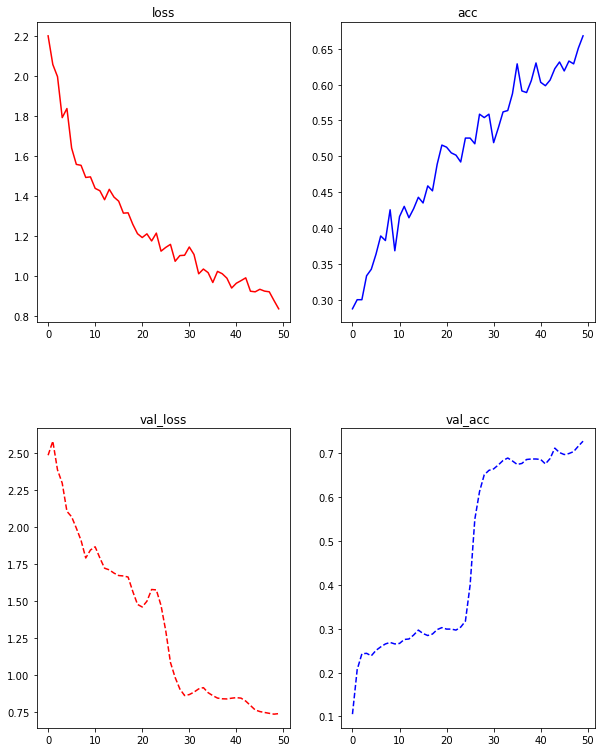

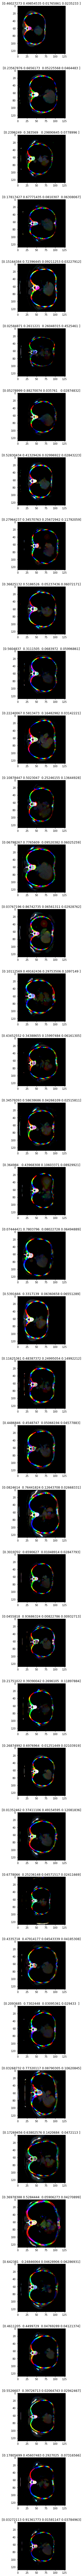

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')
    
preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

for i in range(40):
    ax1[i].imshow(xtrain[i].squeeze())
    ax1[i].title.set_text(str(preds[i]))

In [49]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 222 	accurately-predicted-data: 126 	 wrongly-predicted-data:  96
Accuracy: 56.757 %
